# ADS Thesis Project - Boosting Model CATTLE

**Authors: Marion Späth (2772981)**


This notebook documents the Boosting Models for cattle herders.
The datasets have been created in the R file "ML PREPARATIONS.Rmd".

In [44]:
#!pip install shap
#! pip install catboost
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor, Pool

# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [45]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_cattle_df.csv")
test_cattle.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_cattle,cs_cs_ratio_post_cattle,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,1,4,No,25,Yes,No,Never attended,1,No,0,1,-188.170624,0.0,2,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes,-1.098058,-0.213343,-0.774825,-0.892525,-0.476155,5.242649,-0.429083
1,26,4,No,35,No,No,Never attended,1,No,0,0,-571.529175,0.0,3,Elementary,5,Student,Fully settled: The whole of the household (all...,2,Professional and Organizational Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.496108,-0.213343,-0.159894,0.413594,-0.476155,6.350064,0.659505


# Original Model with Education as a Categorical Variable
### Prepare Datasets for Models

Create dummies for categorical variables and split X and Y values for both test and train data.

In [46]:
# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_cattle = train_cattle["resid_mixed"]

X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults",
                                   "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

#### Specify Categorical Features, Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using grid search including all available hyperparameters and specifying performance metrics to incluede the (negative) mean squared error, (negative) mean absolute error, and R Squared. Sklearn calculate the negative values so that the interpretation of "the higher the better" is valid across all performance metrics.

In [47]:
# Specify categorical variables 
cat_features = ['afm_language', 'agric_land', 'amh_language', 'eng_language', 'expend', 'irrigated_land_bin', 'educ_child_recoded', 'educ_recoded_constant',
                'activity_child_recoded', 'household_description', 'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved',
                'why_not_purchase_recoded', 'know_vip', 'trust_vip'] 


# Ensure categorical columns are string/categorical for compatibility
for col in cat_features:
    X_cattle[col] = X_cattle[col].astype('str')

for col in cat_features:
    X_cattle_TEST[col] = X_cattle_TEST[col].astype('str')

# Instantiate CatBoost Model
catboost_model = CatBoostRegressor(silent=True, random_seed=42)

# Define Hyperparameter Grid
param_grid = {
    'iterations': [50, 60, 70,80,90,100], 
    'learning_rate': [0.01, 0.05, 0.1 ,0.2],
    'depth': [1, 2,5, 7,9,12,15],
}

# Define custom MAE scorer (scikit-learn expects maximization)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Deinfe 10 Fold Cross-Validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Use RandomizedSearchCV, fit on MAE
catboost = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

### Train Model

In [ ]:
%%time
# Fit using CV and categorical info
#catboost.fit(X_cattle, Y_cattle, cat_features=cat_features)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
CPU times: total: 24.2 s
Wall time: 1h 2min 11s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000025F09579010>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': [1, 2, 5, 7, 9, 12, 15],
                                        'iterations': [50, 60, 70, 80, 90, 100],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.2]},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

### Save Model

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'catboost_m1_CATTLEv1.pickle', 'wb') as to_write:
#    pickle.dump(catboost, to_write)

Read in model. Extract best hyperparameter specifications and best model performance.

In [48]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'catboost_m1_CATTLEv1.pickle', 'rb') as to_read:
    catboost_m1v1 = pickle.load(to_read)

# Extract best parameters and score
print("Best parameters:", catboost_m1v1.best_params_)
print("Best MSE (CV):", catboost_m1v1.best_score_)

Best parameters: {'learning_rate': 0.1, 'iterations': 50, 'depth': 5}
Best MSE (CV): -2.663798255022377


### Make Predictions and Calculate Performance Metrics on Testset

In [ ]:
# Make Prediction
best_model = catboost_m1v1.best_estimator_
y_predv1 = best_model.predict(X_cattle_TEST)

rmse = np.sqrt(mean_squared_error(Y_cattle_TEST, y_predv1))
mae = mean_absolute_error(Y_cattle_TEST, y_predv1)
r2 = r2_score(Y_cattle_TEST, y_predv1)

print(f"CatBoost Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

CatBoost Performance on Test Set:
RMSE: 1.6443
MAE:  1.1881
R²:   0.0117


### Inspect Distribution of Residuals

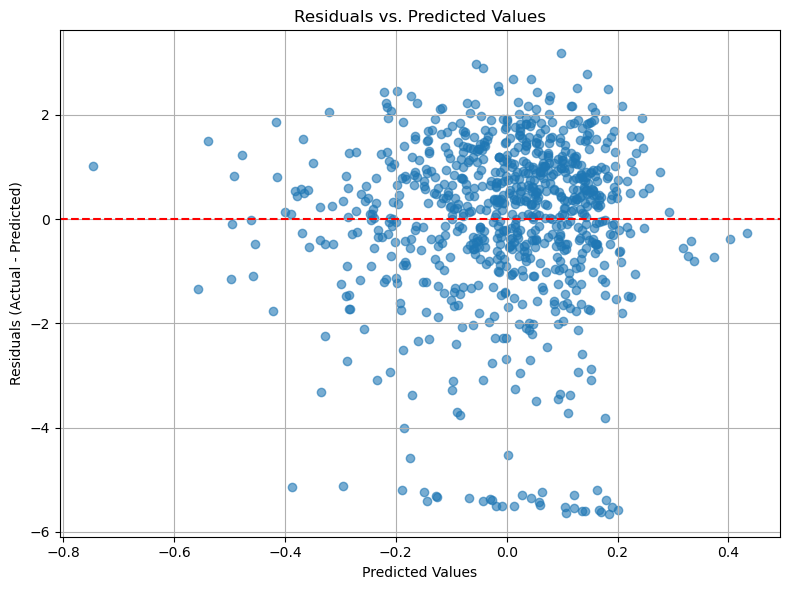

In [18]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_predv1

plt.figure(figsize=(8, 6))
plt.scatter(y_predv1, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


### Plot Actual vs. Predicted Values

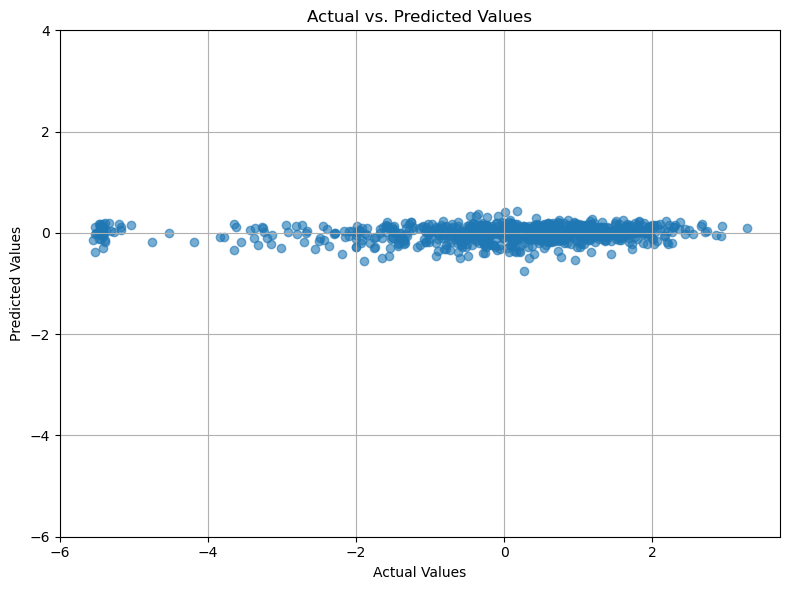

In [19]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_predv1

plt.figure(figsize=(8, 6))
plt.scatter(Y_cattle_TEST, y_predv1, alpha=0.6)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.ylim(-6, 4) 
plt.grid(True)
plt.tight_layout()
plt.show()

## SHAP

### Investigate Shapely Values 

In [73]:
# adjust variable names
labels = {
  "activity_child_recoded": "Child's Activity",
  "trust_vip" : "Trust in VIP",
  "know_vip" : "Knows VIP",
  "educ_recoded_constant" : "Adult's Education",
  "agric_land" : "Owns Agricultural Land",
  "eng_language" : "English Language",
  "why_not_purchase_recoded" : "Reason Non-Purchase",
  "number_minors_z" : "Number of Minors in HH (z)",
  "number_adults_z" : "Number of Adults in HH (z)",
  "owns_phone" : "Owns Phone",
  "religion_recoded" : "Religion",
  "main_info_source_recoded" : "Main Info Source",
  "household_moved" : "Household Moved",
  "household_description" : "Household Status (Fully / Partially / Not Settled)",
  "age_constant_z" : "Age (z)",
  "educ_child_recoded" : "Child's Education",
  "expend" : "Expend",
  "irrigated_land_bin" : "Irrigated Land",
  "amh_language" : "Amh Language",
  "afm_language" : "Afm Language"
}

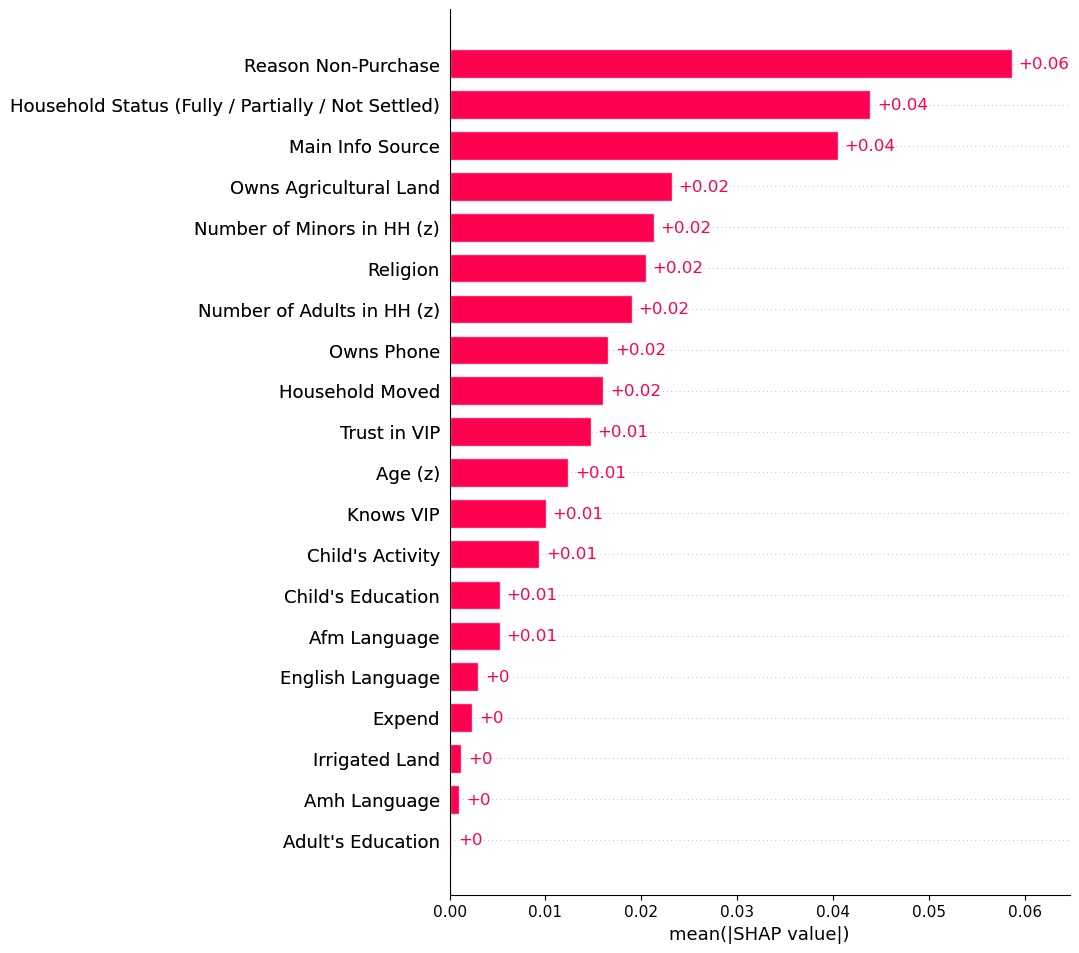

In [ ]:
# Create the CatBoost Pool
X_pool = Pool(data=X_cattle, cat_features=cat_features)

# Create SHAP explainer
explainer = shap.Explainer(best_model)  # assumes your model is already trained

# Get SHAP values
shap_values = explainer(X_pool)

# apply mapping for variable names
custom_names = [labels.get(col, col) for col in X_cattle.columns]  # fallback to original name if not in dict
shap_values.feature_names = custom_names

# Plot all variables
shap.plots.bar(shap_values, max_display=50)

Limit Plot to Top 10

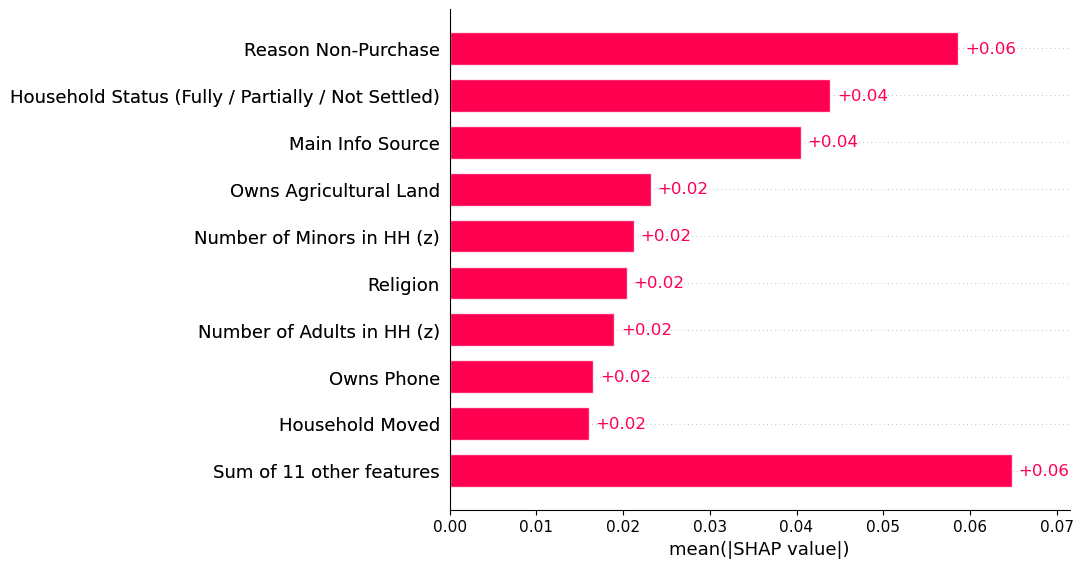

In [54]:
shap.plots.bar(shap_values, max_display=10)

Note that the variables with grey points are categorical, thus the color grading does not apply.

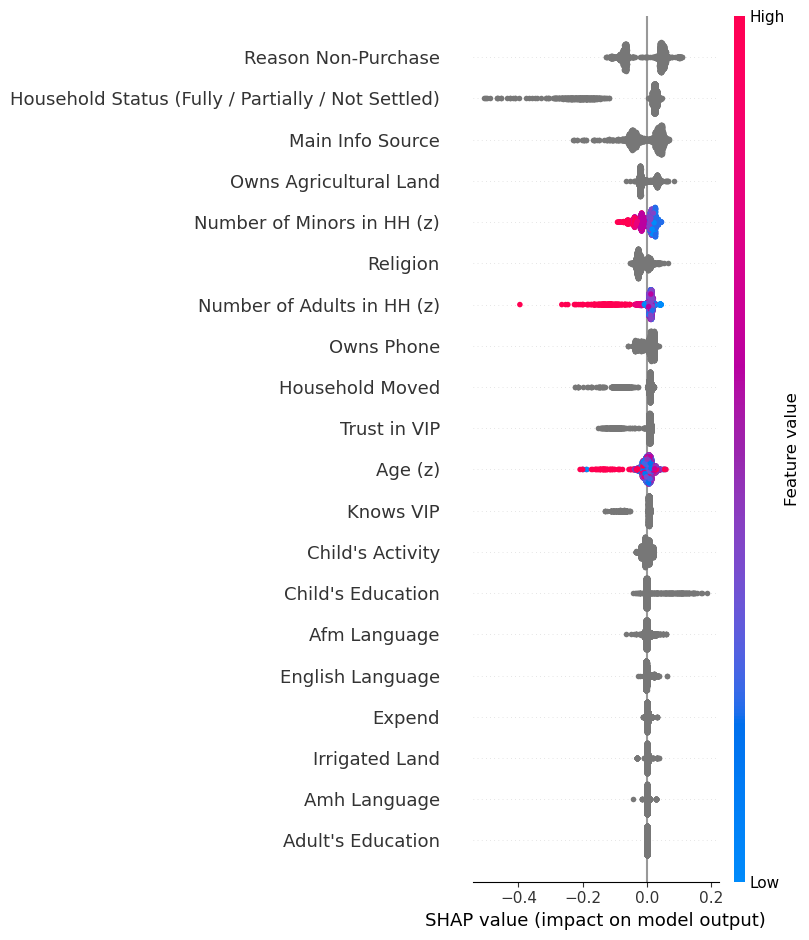

In [59]:
# Summary plot
X_cattle_renamed = X_cattle.rename(columns=labels)

shap.summary_plot(shap_values, features=X_cattle, max_display=50)

Limit to Top 10

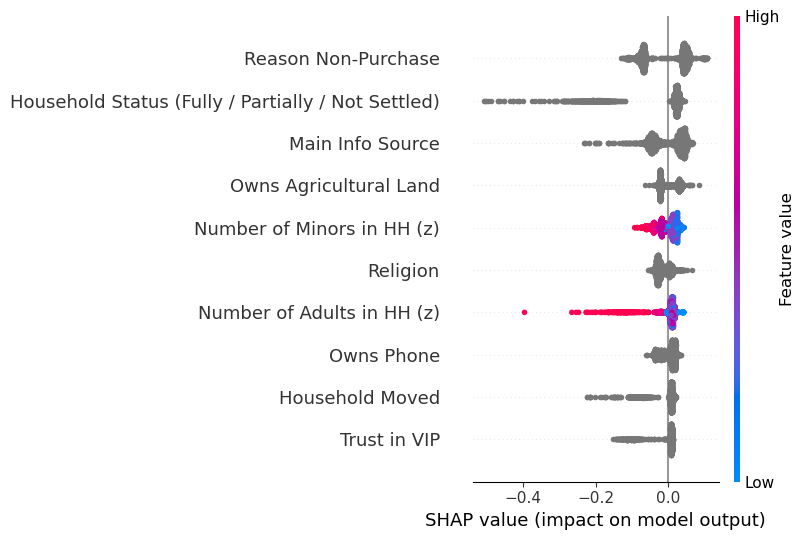

In [60]:
shap.summary_plot(shap_values, features=X_cattle, max_display=10)

### Investigate differences among the categorical variables' categories - For top 3 Categorical Variables

C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_57768\823907499.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


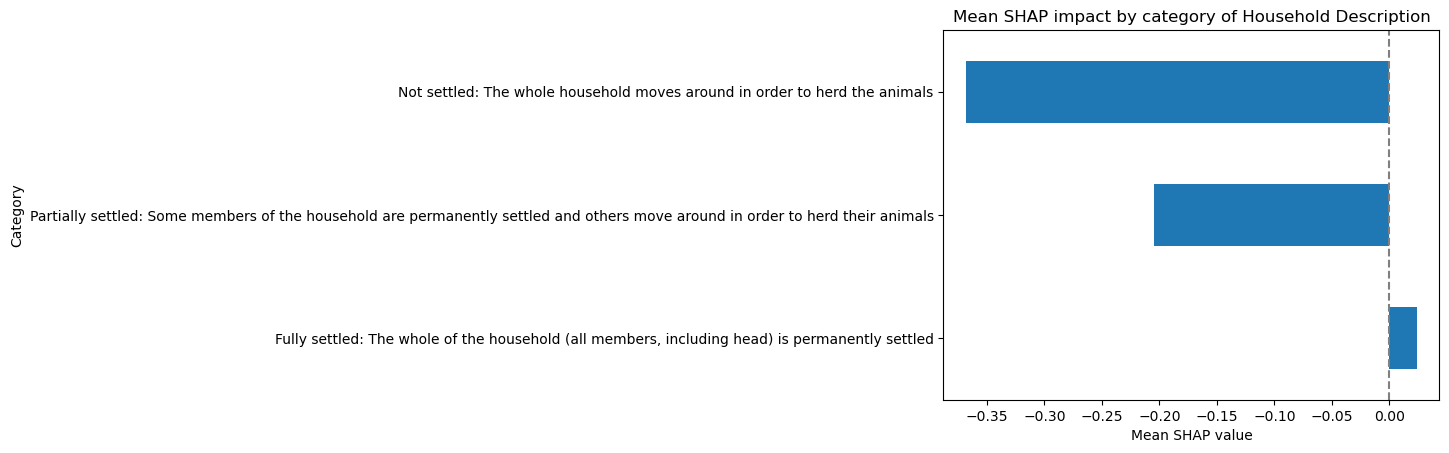

In [56]:
# 1. Create SHAP DataFrame with renamed columns
shap_df = pd.DataFrame(
    shap_values.values,
    columns=[f"{col}_shap" for col in X_cattle.columns]
)

# 2. Join original data and SHAP values
joined = pd.concat([X_cattle.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

# household_description
feature = "household_description"
shap_col = f"{feature}_shap"

category_shap_effects = joined.groupby(feature)[shap_col].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)

category_shap_effects['mean'].plot(kind='barh')
plt.xlabel("Mean SHAP value")
plt.title(f"Mean SHAP impact by category of Household Description")
plt.ylabel("Category")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

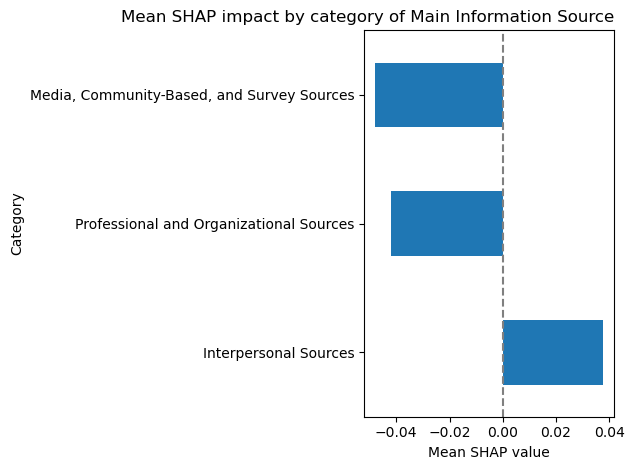

In [57]:
# main_info_source_recoded
feature = "main_info_source_recoded"
shap_col = f"{feature}_shap"

category_shap_effects = joined.groupby(feature)[shap_col].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)

category_shap_effects['mean'].plot(kind='barh')
plt.xlabel("Mean SHAP value")
plt.title(f"Mean SHAP impact by category of Main Information Source", loc='right')
plt.ylabel("Category")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

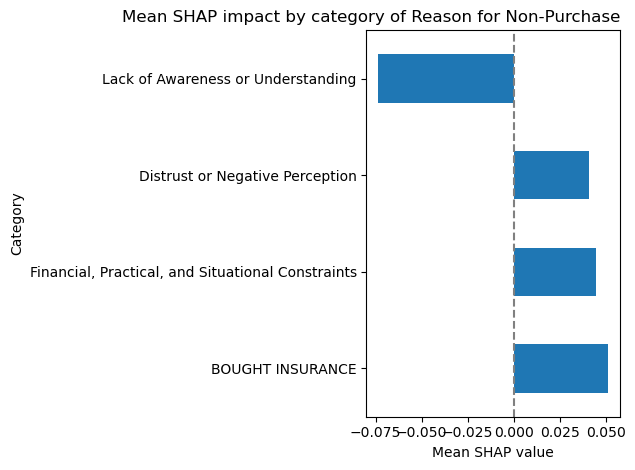

In [58]:
# main_info_source_recoded
feature = "why_not_purchase_recoded"
shap_col = f"{feature}_shap"

category_shap_effects = joined.groupby(feature)[shap_col].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)

category_shap_effects['mean'].plot(kind='barh')
plt.xlabel("Mean SHAP value")
plt.title("Mean SHAP impact by category of Reason for Non-Purchase", loc='right')
plt.ylabel("Category")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

### Get aggregated shapely values --> Overall feature importances

In [ ]:
# aggregate SHAP values to get overall feature importances
feature_importance = pd.Series(
    np.abs(shap_df).mean(axis=0),
    index=shap_df.columns
).sort_values(ascending=True)
feature_importance

educ_recoded_constant_shap       0.000164
amh_language_shap                0.001030
irrigated_land_bin_shap          0.001238
expend_shap                      0.002379
eng_language_shap                0.002988
afm_language_shap                0.005234
educ_child_recoded_shap          0.005252
activity_child_recoded_shap      0.009376
know_vip_shap                    0.010037
age_constant_z_shap              0.012400
trust_vip_shap                   0.014740
household_moved_shap             0.016042
owns_phone_shap                  0.016553
number_adults_z_shap             0.018999
religion_recoded_shap            0.020435
number_minors_z_shap             0.021274
agric_land_shap                  0.023191
main_info_source_recoded_shap    0.040501
household_description_shap       0.043896
why_not_purchase_recoded_shap    0.058660
dtype: float64

### convert to dataframe, give column names and save


In [ ]:
feature_importance = feature_importance.reset_index()
feature_importance.columns = ['feature', 'importance']

,feature,importance
0,educ_recoded_constant_shap,0.000164
1,amh_language_shap,0.001030
2,irrigated_land_bin_shap,0.001238
3,expend_shap,0.002379
4,eng_language_shap,0.002988
5,afm_language_shap,0.005234
6,educ_child_recoded_shap,0.005252
7,activity_child_recoded_shap,0.009376
8,know_vip_shap,0.010037
9,age_constant_z_shap,0.012400


In [71]:
feature_name_map = {
    "educ_recoded_constant_shap": "Adult's Education",
    "amh_language_shap": "Amh Language",
    "irrigated_land_bin_shap": "Irrigated Land",
    "expend_shap": "Expend",
    "eng_language_shap": "English Language",
    "afm_language_shap": "Afm Language",
    "educ_child_recoded_shap": "Child's Education",
    "activity_child_recoded_shap": "Child's Activity",
    "know_vip_shap": "Knows VIP",
    "age_constant_z_shap": "Age (z)",
    "trust_vip_shap": "Trust in VIP",
    "household_moved_shap": "Household Moved",
    "owns_phone_shap": "Owns Phone",
    "number_adults_z_shap": "Number of Adults in HH (z)",
    "religion_recoded_shap": "Religion",
    "number_minors_z_shap": "Number of Minors in HH (z)",
    "agric_land_shap": "Owns Agricultural Land",
    "main_info_source_recoded_shap": "Main Information Source",
    "household_description_shap": "Household Status",
    "why_not_purchase_recoded_shap": "Reason Non-Purchase"
}

feature_importance["feature"] = feature_importance["feature"].replace(feature_name_map)
feature_importance

,feature,importance
0,Adult's Education,0.000164
1,Amh Language,0.001030
2,Irrigated Land,0.001238
3,Expend,0.002379
4,English Language,0.002988
5,Afm Language,0.005234
6,Child's Education,0.005252
7,Child's Activity,0.009376
8,Knows VIP,0.010037
9,Age (z),0.012400


In [72]:
feature_importance.to_csv("feature_importance_catboost_cattle.csv", header=True, index=False)

# Refit using Education Variables as Numeric Variables

Goal: By (slightly) reducing the number of categorical variables, and increasing the number of numeric variables, the R2 might be increased. 

In [20]:
# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_recoded_constant", 
                              "educ_child_recoded", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_cattle = train_cattle["resid_mixed"]

X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_recoded_constant", 
                              "educ_child_recoded", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

In [21]:
X_cattle_TEST.columns

Index(['afm_language', 'agric_land', 'amh_language', 'eng_language', 'expend',
       'irrigated_land_bin', 'activity_child_recoded', 'household_description',
       'main_info_source_recoded', 'religion_recoded', 'owns_phone',
       'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip',
       'age_constant_z', 'number_adults_z', 'number_minors_z', 'educ_child_z',
       'educ_adult_z'],
      dtype='object')

In [ ]:
# Specify categorical variables 
cat_features = ['afm_language', 'agric_land', 'amh_language', 'eng_language', 'expend', 'irrigated_land_bin','activity_child_recoded', 'household_description', 
                'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip'] 


# Ensure categorical columns are string/categorical for compatibility
for col in cat_features:
    X_cattle[col] = X_cattle[col].astype('str')

for col in cat_features:
    X_cattle_TEST[col] = X_cattle_TEST[col].astype('str')

# Instantiate CatBoost Model
catboost_model = CatBoostRegressor(silent=True, random_seed=42)

# Define Hyperparameter Grid
param_grid = {
    'iterations': [50, 60, 70,80,90,100], 
    'learning_rate': [0.01, 0.05, 0.1 ,0.2],
    'depth': [1, 2,5, 7,9,12,15],
}

# Define custom MAE scorer (scikit-learn expects maximization)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define 10 Fold Cross-Validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Use RandomizedSearchCV, fit on MAE
catboost = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

#catboost.fit(X_cattle, Y_cattle, cat_features=cat_features)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000025F12E4BFB0>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': [1, 2, 5, 7, 9, 12, 15],
                                        'iterations': [50, 60, 70, 80, 90, 100],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.2]},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'catboost_m2_CATTLEv1.pickle', 'wb') as to_write:
#    pickle.dump(catboost, to_write)

In [ ]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'catboost_m2_CATTLEv1.pickle', 'rb') as to_read:
    catboost_m2v1 = pickle.load(to_read)

# Extract best parameters and score
print("Best parameters:", catboost_m2v1.best_params_)
print("Best MSE (CV):", catboost_m2v1.best_score_)

Best parameters: {'learning_rate': 0.05, 'iterations': 60, 'depth': 7}
Best MAE (CV): -2.6613277038817253


In [27]:
# Make Prediction NEW
best_model = catboost_m2v1.best_estimator_
y_predm2v1 = best_model.predict(X_cattle_TEST)

rmse = np.sqrt(mean_squared_error(Y_cattle_TEST, y_predm2v1))
mae = mean_absolute_error(Y_cattle_TEST, y_predm2v1)
r2 = r2_score(Y_cattle_TEST, y_predm2v1)

print(f"CatBoost Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

CatBoost Performance on Test Set:
RMSE: 1.6414
MAE:  1.1866
R²:   0.0152


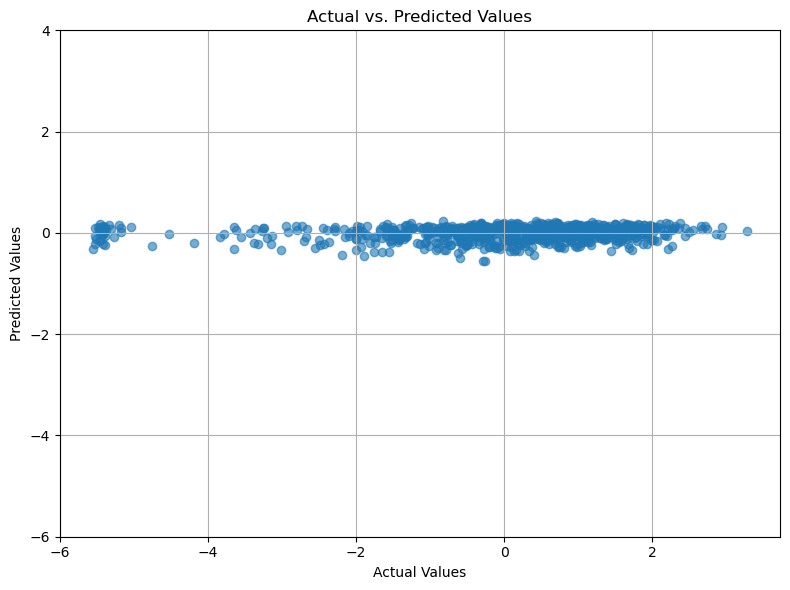

In [28]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_predm2v1

plt.figure(figsize=(8, 6))
plt.scatter(Y_cattle_TEST, y_predm2v1, alpha=0.6)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.ylim(-6, 4) 
plt.grid(True)
plt.tight_layout()
plt.show()